# Intuition sur le fonctionnement de la méthode

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import plotly.graph_objects as go
from PIL import Image
from utils import unify_coordinates_referential

data = pd.read_csv("../data/clean_data.csv")
data = unify_coordinates_referential(data)

In [6]:
# Filter data for the 2017 season and SJS team
sjs_data = data[(data['season'] == 2017) & ((data['homeTeam'] == 'SJS') | (data['awayTeam'] == 'SJS'))]

# Filter data for the 2017 season for the entire league
league_data_2017 = data[data['season'] == 2017]

sjs_data.head()

,gameId,season,gameType,gameDate,homeTeam,awayTeam,rinkSide,period,periodTime,byTeam,eventType,shotType,coordinateX,coordinateY,shooterName,goalieName,strength,emptyNet
80606,2017020004,2017,R,2017-10-05,SJS,PHI,left,1,00:33,SJS,SHOT,Backhand,-29.0,40.0,Mikkel Boedker,Brian Elliott,NaN,False
80607,2017020004,2017,R,2017-10-05,SJS,PHI,left,1,01:05,SJS,SHOT,Slap Shot,28.0,-24.0,Brent Burns,Brian Elliott,NaN,False
80608,2017020004,2017,R,2017-10-05,SJS,PHI,left,1,01:10,SJS,SHOT,Snap Shot,31.0,15.0,Brent Burns,Brian Elliott,NaN,False
80609,2017020004,2017,R,2017-10-05,SJS,PHI,left,1,01:28,PHI,SHOT,Wrist Shot,63.0,-11.0,Nolan Patrick,Martin Jones,NaN,False
80610,2017020004,2017,R,2017-10-05,SJS,PHI,left,1,02:50,PHI,SHOT,Wrist Shot,63.0,20.0,Ivan Provorov,Martin Jones,NaN,False


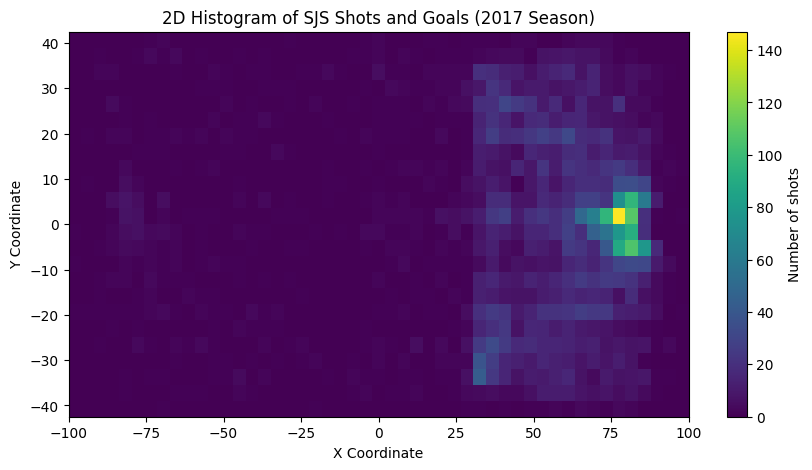

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Define bins for histogram
x_bins = np.linspace(-100, 100, 50)
y_bins = np.linspace(-42.5, 42.5, 25)

# Create 2D histogram for SJS shots and goals
sjs_hist, x_edges, y_edges = np.histogram2d(sjs_data['coordinateX'], sjs_data['coordinateY'], bins=[x_bins, y_bins])

# Plot the histogram
plt.figure(figsize=(10, 5))
plt.pcolormesh(x_edges, y_edges, sjs_hist.T, shading='auto', cmap='viridis')
plt.colorbar(label='Number of shots')
plt.title('2D Histogram of SJS Shots and Goals (2017 Season)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

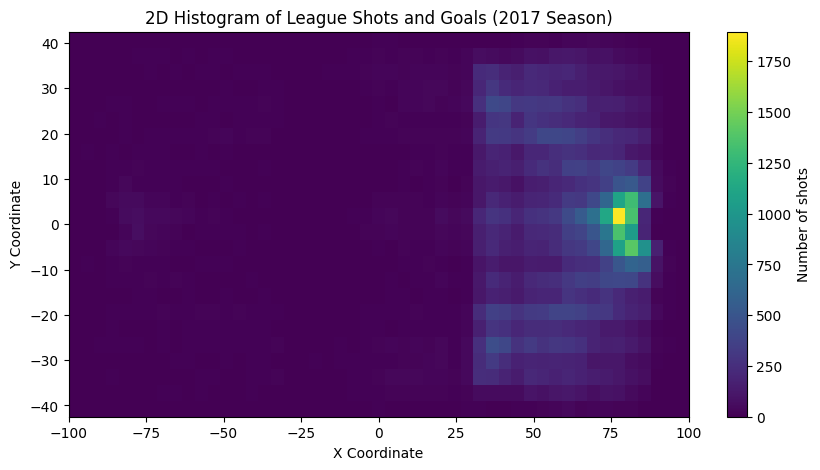

In [8]:
# Create 2D histogram for the entire league's shots and goals in 2017 season
league_hist, _, _ = np.histogram2d(league_data_2017['coordinateX'], league_data_2017['coordinateY'], bins=[x_bins, y_bins])

# Plot the histogram
plt.figure(figsize=(10, 5))
plt.pcolormesh(x_edges, y_edges, league_hist.T, shading='auto', cmap='viridis')
plt.colorbar(label='Number of shots')
plt.title('2D Histogram of League Shots and Goals (2017 Season)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

In [9]:
# Determine the number of games played by SJS in 2017
sjs_games_played = sjs_data['gameId'].nunique()

# Determine the total number of games in the league in 2017
total_league_games = league_data_2017['gameId'].nunique()

# Compute per-hour averages for histograms
sjs_hist_per_hour = sjs_hist / sjs_games_played
league_hist_per_hour = league_hist / total_league_games

sjs_games_played, total_league_games

(92, 1355)

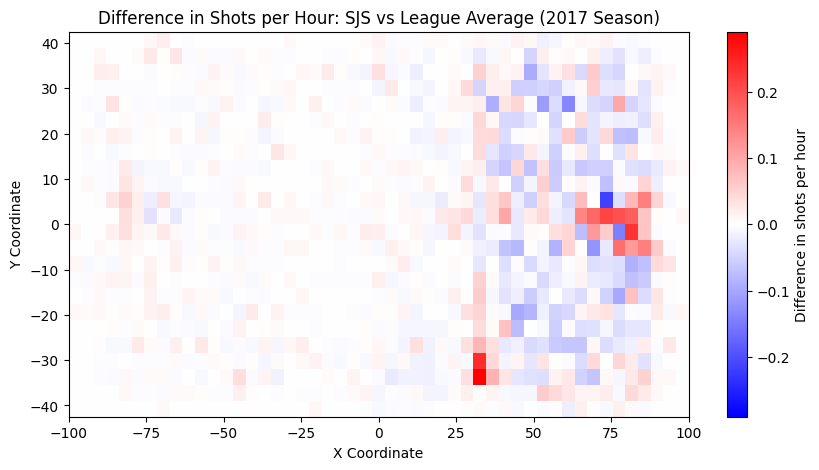

In [10]:
# Compute the difference between SJS and league averages
difference_hist = sjs_hist_per_hour - league_hist_per_hour

# Plot the difference histogram
plt.figure(figsize=(10, 5))
plt.pcolormesh(x_edges, y_edges, difference_hist.T, shading='auto', cmap='bwr', vmin=-difference_hist.max(), vmax=difference_hist.max())
plt.colorbar(label='Difference in shots per hour')
plt.title('Difference in Shots per Hour: SJS vs League Average (2017 Season)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

Ensuite il ne suffit que de faire un KDE et d'en faire le graphique

# Pyplots

In [58]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import requests
import base64
from scipy.ndimage import gaussian_filter
import plotly.figure_factory as ff
from utils import unify_coordinates_referential

def compute_histograms(data, season_year, team_dict):
    
    x_bins = np.linspace(-100, 100, 50)
    y_bins = np.linspace(-42, 42, 21)
    hists = {}
    teams_to_remove = []

    for team_abbreviation, full_name in team_dict.items():
        team_data = data[(data["season"] == season_year) & (data["byTeam"] == team_abbreviation)]
        team_data = team_data.dropna(subset=["coordinateX", "coordinateY"])
        n_game = team_data["gameId"].nunique()
        if n_game == 0:
            teams_to_remove.append(team_abbreviation)
            continue
        team_hist, _, _ = np.histogram2d(team_data["coordinateX"], team_data["coordinateY"], bins=[x_bins, y_bins])
        hists[team_abbreviation] = team_hist / n_game

    # Remove teams with no games
    for team in teams_to_remove:
        del team_dict[team]

    league_hist_shape = (len(x_bins) - 1, len(y_bins) - 1)
    league_hist = np.zeros(league_hist_shape)

    for team_hist in hists.values():
        league_hist += team_hist

    league_hist /= len(hists)
    for team_abbreviation in hists.keys():
        hists[team_abbreviation] -= league_hist

    return (hists, team_dict)

In [59]:
data = pd.read_csv("../data/clean_data.csv")
data = unify_coordinates_referential(data)

In [60]:
response = requests.get('https://statsapi.web.nhl.com/api/v1/teams')
temp = response.json()
team_dict = {team['abbreviation']: team['name'] for team in temp['teams']}

In [104]:
def plot_team_vs_league_interactive_contour_adjusted(data, team_abbreviation, season_year):

    # Differential histograms
    difference_hists, new_team_dict = compute_histograms(data, season_year, team_dict)

    # Differential histogram for chosen team
    difference_team = difference_hists[team_abbreviation]
    team_full_name = new_team_dict.get(team_abbreviation, team_abbreviation)

    # Gaussian kernel smoothing
    smoothed_difference = gaussian_filter(difference_team, sigma=2.5)

    x_bins = np.linspace(-100, 100, 50)
    y_bins = np.linspace(-42, 42, 21)
    x_edges = (x_bins[:-1] + x_bins[1:]) / 2
    y_edges = (y_bins[:-1] + y_bins[1:]) / 2

    # Create a contour plot with red for positive values and blue for negative values
    # Create a contour plot with red for positive values and blue for negative values
    contour = go.Figure(data=go.Contour(z=smoothed_difference.T,
                                x=x_edges,
                                y=y_edges,
                                colorscale=[(0, "blue"), ((0 - np.min(smoothed_difference)) / (np.max(smoothed_difference) - np.min(smoothed_difference)), "white"), (1, "red")],
                                zmid=0,
                                ncontours=35,
                                line_smoothing=1.3,
                                colorbar_title="Excès moyen de tirs"))
    
    # Add title and labels with adjusted aspect ratio
    contour.update_layout(
        title=f'Excès moyen de tirs par emplacement: {team_full_name} vs moyenne de la ligue ({season_year})',
        xaxis_title="Coordonnée X",
        yaxis_title="Coordonnée Y",
        xaxis=dict(showgrid=True, gridwidth=0.5, gridcolor='gray', range=[-98, 98]),
        yaxis=dict(showgrid=True, gridwidth=0.5, gridcolor='gray', range=[-40, 40]),
        width=1305,
        height=715,
        title_x=0.5,
        title_y=0.9
    )

    def image_to_base64(img_path):
        with open(img_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode('utf-8')

    hockey_rink_img_base64 = "data:image/png;base64," + image_to_base64("../hockey_rink_transparent.png")

    contour.add_layout_image(dict(
        source=hockey_rink_img_base64,
        xref="x",
        yref="y",
        x=-98,  # Adjust this to move the rink left or right
        y=40,  # Adjust this to move the rink up or down
        sizex=200,  # Size is made consistent with the contour plot range
        sizey=80,  # Size is kept the same
        opacity=0.7,
        layer="above")
    )

    return contour

plot_team_vs_league_interactive_contour_adjusted(data, "SJS", 2017)

In [112]:
def interactive_plot_with_dropdown(season_year):
    fig = go.Figure()

    # Differential histograms
    difference_hists, new_team_dict = compute_histograms(data, season_year, team_dict)

    for team_abbreviation in new_team_dict.keys():
        # Differential histogram for chosen team
        difference_team = difference_hists[team_abbreviation]
        team_full_name = new_team_dict.get(team_abbreviation, team_abbreviation)

        # Gaussian kernel smoothing
        smoothed_difference = gaussian_filter(difference_team, sigma=2.5)
        x_bins = np.linspace(-100, 100, 50)
        y_bins = np.linspace(-42, 42, 21)
        x_edges = (x_bins[:-1] + x_bins[1:]) / 2
        y_edges = (y_bins[:-1] + y_bins[1:]) / 2

        # Add each team's contour to the figure, but hide all by default
        fig.add_trace(go.Contour(z=smoothed_difference.T,
                                 x=x_edges,
                                 y=y_edges,
                                 colorscale=[(0, "blue"), ((0 - np.min(smoothed_difference)) / (np.max(smoothed_difference) - np.min(smoothed_difference)), "white"), (1, "red")],
                                 zmid=0,
                                 ncontours=35,
                                 line_smoothing=1.3,
                                 visible=(team_abbreviation == 'NJD'),
                                 colorbar_title="Excès moyen de tirs"))

    # Dropdown menu creation
    updatemenu = []
    buttons = []

    for i, team_abbreviation in enumerate(new_team_dict.keys()):
        visible = [False] * len(new_team_dict)
        visible[i] = True
        button = dict(label=new_team_dict[team_abbreviation],
                      method="update",
                      args=[{"visible": visible},
                            {"title": f"Excès moyen de tirs par emplacement: {team_full_name} vs moyenne de la ligue ({season_year})"}])
        buttons.append(button)

    updatemenu.append(dict(buttons=buttons, direction="down",
                           showactive=True, x=0, xanchor="left", y=1.2, yanchor="top"))

    # Add the dropdown to the figure
    fig.update_layout(updatemenus=updatemenu)

    # Base layout settings that apply regardless of the team selected
    fig.update_layout(
        title=f"Excès moyen de tirs par emplacement: New Jersey Devils vs moyenne de la ligue ({season_year})",
        xaxis_title="Coordonnée X",
        yaxis_title="Coordonnée Y",
        xaxis=dict(showgrid=True, gridwidth=0.5, gridcolor='gray', range=[-98, 98]),
        yaxis=dict(showgrid=True, gridwidth=0.5, gridcolor='gray', range=[-40, 40]),
        title_x=0.5,
        title_y = 0.9,
        width=1274,
        height=715,
    )

    def image_to_base64(img_path):
        with open(img_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode('utf-8')

    hockey_rink_img_base64 = "data:image/png;base64," + image_to_base64("../hockey_rink_transparent.png")

    fig.add_layout_image(dict(
        source=hockey_rink_img_base64,
        xref="x",
        yref="y",
        x=-98,
        y=40,
        sizex=200,
        sizey=80,
        opacity=0.7,
        layer="above")
    )

    return fig

# Display the contour plot with a dropdown menu for team selection
interactive_plot_with_dropdown(2017)

In [113]:
import plotly.offline as pyo
import plotly.graph_objs as go
import numpy as np
from scipy.ndimage import gaussian_filter
import os

# Check if 'pyplots' directory exists, and create it if not
if not os.path.exists('pyplots'):
    os.makedirs('pyplots')

for season in range(2016, 2021):
    fig = interactive_plot_with_dropdown(season)
    pyo.plot(fig, filename=f'pyplots/season_{season}.html')